In [1]:
#!pip install statsmodels
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
palette = 'Set2'
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, normaltest
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 180)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [7]:
df = pd.read_csv('/Users/Ilya/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [8]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(90,'~'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(90,'~'))
    print(dataframe.dtypes)
    print(" HEAD ".center(90,'~'))
    print(dataframe.head(head))
    print(" TAIL ".center(90,'~'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(90,'~'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(90,'~'))
    print(dataframe.duplicated().sum())
    print(" DESCRIBE ".center(90,'~'))
    print(dataframe.describe().T)
    
check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ SHAPE ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Rows: 90189
Columns: 5
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TYPES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ TAIL ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        userid  version  sum_gamerounds  retention_1  retention_7
90184  9999441  gate_40              97   

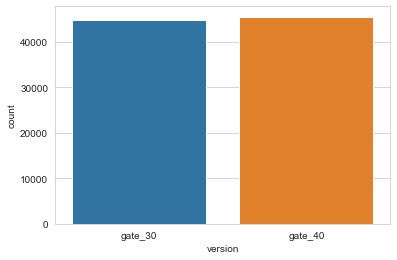

In [11]:
#Let's see the graph for better understanding.
df.groupby("version")["userid"].count()
sns.countplot(x="version",data=df);

In [12]:
df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}).reset_index()

version sum_gamerounds         
                    count     mean
0  gate_30          44700 52.45626
1  gate_40          45489 51.29878

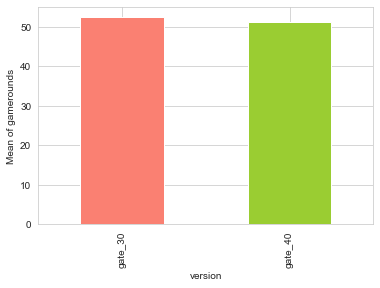

In [13]:
df.groupby("version")["sum_gamerounds"].mean()
df.groupby("version")["sum_gamerounds"].mean().plot(kind="bar", color=[ "salmon", "yellowgreen"]);

plt.ylabel("Mean of gamerounds");

In [14]:
#Before the outlier value
df.sum_gamerounds.describe()

count   90189.00000
mean       51.87246
std       195.05086
min         0.00000
25%         5.00000
50%        16.00000
75%        51.00000
max     49854.00000
Name: sum_gamerounds, dtype: float64

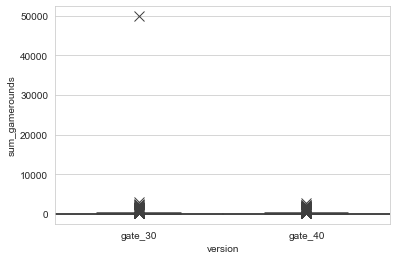

In [15]:
#There is a outlier value in "gate_30".
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=1.0, fliersize=10);

In [18]:
# let's write a function to get rid of the outlier values.
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [19]:
replace_with_thresholds(df, "sum_gamerounds")

In [20]:
#After  removing the outlier value
df.sum_gamerounds.describe()

count   90189.00000
mean       51.10922
std        99.31228
min         0.00000
25%         5.00000
50%        16.00000
75%        51.00000
max      1232.50000
Name: sum_gamerounds, dtype: float64

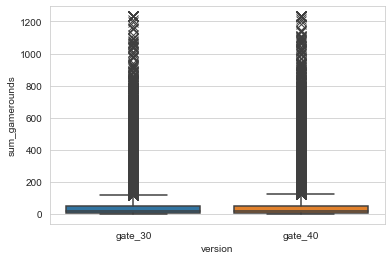

In [21]:
#I saw more logical graph.
sns.boxplot(data=df, x="version", y="sum_gamerounds", flierprops={"marker": "x"}, width=0.8, fliersize=10);

# A/B Testing.

1.Establish the Hypothesis
H0: M1 = M2
H1: M1 != M2
In this case,

H0: M1 = M2 --- There is no statistical difference between the gate_30 and the gate_40.

H1: M1 != M2 -- There is statistical difference between the gate_30 and the gate_40.

2. Assumption Check
It may be helpful to perform outlier analysis and correction before testing for normality.
Normality Assumption (Shapiro Test)

H0: Distribution is Normal
H1: Distribution is not Normal
p-value check

p-value < 0.05 : H0 is rejected
p-value > 0.05 : H0 can't rejected
Variance Homogeneity (Levene Test)

H0: Variance is homogeneous
H1: Variance is not homogeneous

3. Implementation of the Hypothesis
If the distribution is Normal and the variances are Homogeneous; apply the T-Test (parametric test)
If the distribution is Normal and the variances are not Homogeneous; apply Welch Test
If the distribution is not Normal; apply Mann Whitney U Test directly (non-parametric test)

4.Interpret results based on p-value and evaluate the the Hypothesis
p-value < 0.05 : H0 is rejected
p-value > 0.05 : H0 can't rejected

In [22]:
def AB_Test(df, pthres=0.05):
    
    # H0:  There is no statistical difference between the gate_30 and the gate_40.
    
    print(df.groupby('version').agg({"sum_gamerounds": ["count", "mean"]}))

    print("NORMAL DISTRIBUTION ASSUMPTION" .center(70,"*"))
    
    # H0 : The compared groups have a normal distribution
    
    pvalue_gate_30 = shapiro([df["version"] == "gate_30"])[1]
    pvalue_gate_40 = shapiro([df["version"] == "gate_40"])[1]
    
    print('p-value_gate30 = %.5f' % (pvalue_gate_30))
    print('p-value_gate40 = %.5f' % (pvalue_gate_40))

    if (pvalue_gate_30 < pthres) & (pvalue_gate_40 < pthres):
        print("Normality H0 is rejected.\n\n")
    else:
        print("Normality H0 is not rejected.\n")

    print("VARIANCE HOMOGENEOUS ASSUMPTION ".center(70,"*"))
    
    # H0 : The variance of compared groups is homegenous.
    
    p_value_levene = levene(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                            df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
    
    print('p_value_levene = %.5f' % p_value_levene)

    if p_value_levene < pthres:
        print("Variance Homogeneity H0 is rejected.\n")
    else:
        print("Variance Homogeneity H0 is not rejected.\n")

    if ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene > pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=True)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)

    elif ((pvalue_gate_30 > pthres) & (pvalue_gate_40 > pthres)) & (p_value_levene < pthres):
        p_value_ttest = ttest_ind(df.loc[df["version"] == "gate_30"],
                                  df.loc[df["version"] == "gate_40"],
                                  equal_var=False)[1]
        
        print('p_value_ttest = %.5f' % p_value_ttest)
    else:
        print("Non-Parametric test should be done.\n\n")
        pvalue = mannwhitneyu(df.loc[df["version"] == "gate_30", "sum_gamerounds"],
                              df.loc[df["version"] == "gate_40", "sum_gamerounds"])[1]
        
        print('p_value = %.5f' % pvalue)

    print(" RESULT ".center(70,"*"))

    if pvalue < pthres:
        print(
            f"p-value {round(pvalue, 5)} < 0.05  H0 Hypothesis is Rejected. That is, there is a statistically significant difference between them.")

    else:
        print(
            f"p-value > {pthres} H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.")
AB_Test(df,0.05)

        sum_gamerounds         
                 count     mean
version                        
gate_30          44700 51.15342
gate_40          45489 51.06579
********************NORMAL DISTRIBUTION ASSUMPTION********************
p-value_gate30 = 0.00000
p-value_gate40 = 0.00000
Normality H0 is rejected.


*******************VARIANCE HOMOGENEOUS ASSUMPTION *******************
p_value_levene = 0.83018
Variance Homogeneity H0 is not rejected.

Non-Parametric test should be done.


p_value = 0.05021
******************************* RESULT *******************************
p-value > 0.05 H0 is Not Rejected, That is, there is no statistically significant difference between them. The difference was made by chance.


# Conclusion.

There is no statistically significant difference between the "gate_30" and the "gate_40". The difference was made by chance.
Therefore, The company should keep using gate_30 because we have statistical evidence with 95% confidence.